In [7]:
import pandas as pd

# Load dataset
df = pd.read_csv('recovery_logs.csv')

# View dataset structure
print("Shape:", df.shape)
print("\nHead:")
print(df.head())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Data types
print("\nData Types:")
print(df.dtypes)


Shape: (15000, 8)

Head:
  patient_id  day  pain_score  temperature     mood  sleep_hours wound_check  \
0    L200001    1           6         98.2     Good            7       Clean   
1    L200001    2           4         99.1  Anxious            8     Redness   
2    L200001    3           8         98.6      Low            6     Redness   
3    L200001    4           2         98.5     Good            7       Clean   
4    L200001    5           1         98.5   Stable            6       Clean   

  recovery_flag  
0      On Track  
1       At Risk  
2       At Risk  
3      On Track  
4      On Track  

Missing Values:
patient_id       0
day              0
pain_score       0
temperature      0
mood             0
sleep_hours      0
wound_check      0
recovery_flag    0
dtype: int64

Data Types:
patient_id        object
day                int64
pain_score         int64
temperature      float64
mood              object
sleep_hours        int64
wound_check       object
recovery_flag   

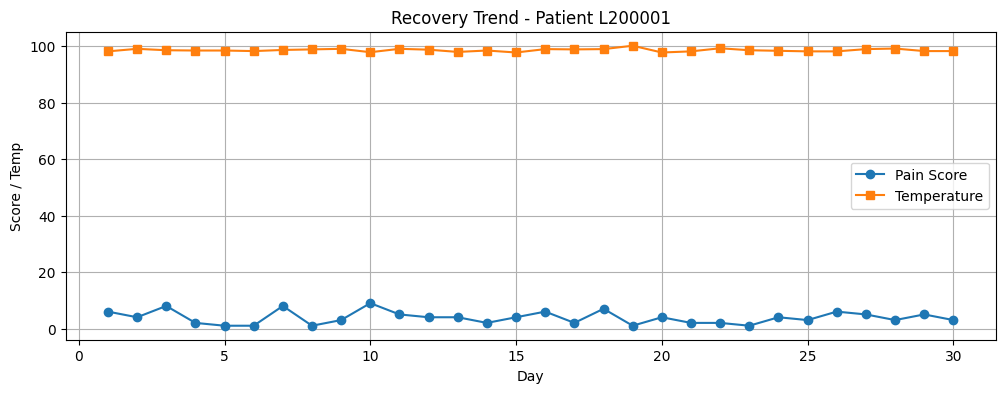

In [8]:
# Kernel 2: Group and Plot Trends

import matplotlib.pyplot as plt
import seaborn as sns

# Plot trend for a sample patient
sample_patient = df['patient_id'].unique()[0]
df_sample = df[df['patient_id'] == sample_patient]

plt.figure(figsize=(12, 4))
plt.plot(df_sample['day'], df_sample['pain_score'], marker='o', label='Pain Score')
plt.plot(df_sample['day'], df_sample['temperature'], marker='s', label='Temperature')
plt.title(f'Recovery Trend - Patient {sample_patient}')
plt.xlabel('Day')
plt.ylabel('Score / Temp')
plt.legend()
plt.grid(True)
plt.show()


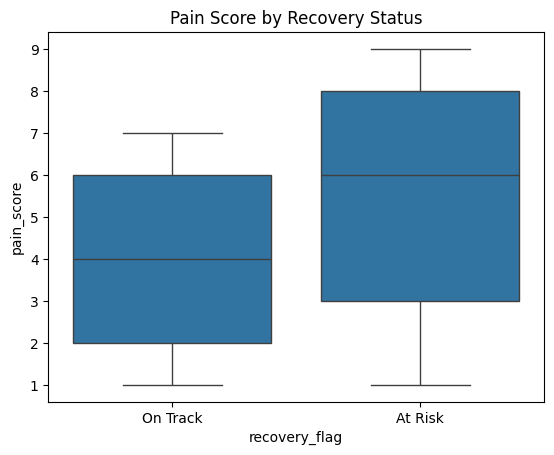

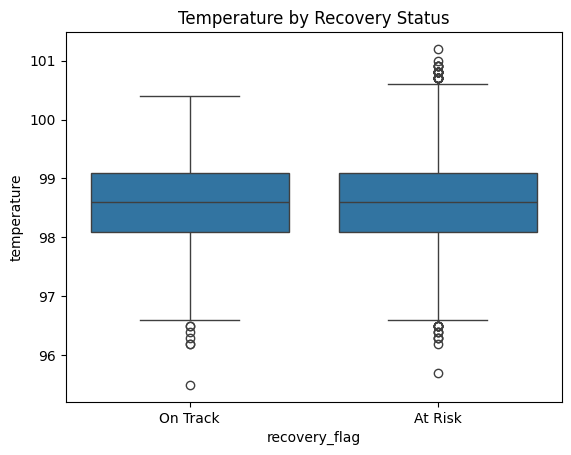

In [9]:
# Kernel 3: Compare Distributions for Recovery Groups

sns.boxplot(x='recovery_flag', y='pain_score', data=df)
plt.title("Pain Score by Recovery Status")
plt.show()

sns.boxplot(x='recovery_flag', y='temperature', data=df)
plt.title("Temperature by Recovery Status")
plt.show()


In [10]:
# Kernel 4: Encode Categorical Values

from sklearn.preprocessing import LabelEncoder

df_encoded = df.copy()
label_cols = ['mood', 'wound_check', 'recovery_flag']
label_encoders = {}

for col in label_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le

print("Encoded Data Sample:")
print(df_encoded.head())


Encoded Data Sample:
  patient_id  day  pain_score  temperature  mood  sleep_hours  wound_check  \
0    L200001    1           6         98.2     1            7            0   
1    L200001    2           4         99.1     0            8            3   
2    L200001    3           8         98.6     2            6            3   
3    L200001    4           2         98.5     1            7            0   
4    L200001    5           1         98.5     3            6            0   

   recovery_flag  
0              1  
1              0  
2              0  
3              1  
4              1  


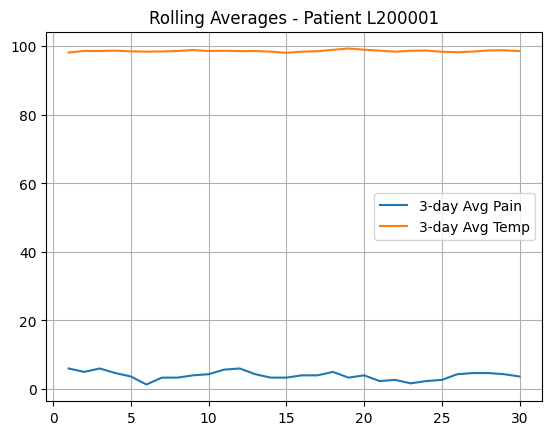

In [12]:
# Kernel 5: Rolling Averages for Trend Detection

df_encoded['pain_roll3'] = df_encoded.groupby('patient_id')['pain_score'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
df_encoded['temp_roll3'] = df_encoded.groupby('patient_id')['temperature'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

# Plot rolling average trend for sample patient
plt.plot(df_sample['day'], df_encoded[df_encoded['patient_id'] == sample_patient]['pain_roll3'], label='3-day Avg Pain')
plt.plot(df_sample['day'], df_encoded[df_encoded['patient_id'] == sample_patient]['temp_roll3'], label='3-day Avg Temp')
plt.title(f'Rolling Averages - Patient {sample_patient}')
plt.legend()
plt.grid(True)
plt.show()


In [13]:
# Kernel 6: Model for Predicting Recovery Status

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Define features and label
features = ['pain_score', 'temperature', 'sleep_hours', 'pain_roll3', 'temp_roll3']
X = df_encoded[features]
y = df_encoded['recovery_flag']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.68      0.68      0.68      1794
           1       0.52      0.51      0.52      1206

    accuracy                           0.61      3000
   macro avg       0.60      0.60      0.60      3000
weighted avg       0.61      0.61      0.61      3000



In [14]:
# Kernel 7: Alert Rules Based on Thresholds

# Simple alert rule
def alert_rule(row):
    return 1 if (row['pain_roll3'] > 7 and row['temp_roll3'] > 100.4) else 0

df_encoded['alert_flag'] = df_encoded.apply(alert_rule, axis=1)

# Check flagged cases
alerts = df_encoded[df_encoded['alert_flag'] == 1]
print(f"Alerts Raised: {alerts.shape[0]}")
print(alerts[['patient_id', 'day', 'pain_roll3', 'temp_roll3', 'alert_flag']].head())


Alerts Raised: 0
Empty DataFrame
Columns: [patient_id, day, pain_roll3, temp_roll3, alert_flag]
Index: []
